# Training a RNN model using the basic negation data (version 1)


## Here we will use the RNN model to distinguish between to kind of sentences:

- 1) A, not A (contradiction)

- 2) not A, A (contradiction)

- 3) A, not B (non-contradiction)

- 4) not B, A (non-contradiction)



In [1]:
# all imports
import numpy as np
import pandas as pd
import torch
from torchtext import data
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

import os
import inspect
import sys
import itertools

almost_current = os.path.abspath(inspect.getfile(inspect.currentframe()))
currentdir = os.path.dirname(almost_current)
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from plots.functions  import plot_confusion_matrix, plot_histogram_from_labels
from text_processing.functions import simple_pre_process_text_df, simple_pre_process_text

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_v1_train.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_v1_test.csv")

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [3]:
train_data.head()

,sentence1,sentence2,label
0,Brooke is not helpful,Brooke is helpful,1
1,Boo is not clever,Boo is clever,1
2,Doe is not poor,Doe is poor,1
3,Hodgson is ambitious,Hodgson is not ambitious,1
4,Hobbes is proud,Marston is not easy,0


In [4]:
test_data.head()

,sentence1,sentence2,label
0,Oakley is brave,Oakley is not brave,1
1,Jean is not alive,Jean is alive,1
2,Starlit is proud,Starlit is not proud,1
3,Temple is not delightful,Westcott is wrong,0
4,Jazz is jolly,Jazz is not jolly,1


## Putting the sentences together

In [5]:
train_data["text"] = train_data["sentence1"]  + ", " + train_data["sentence2"]
test_data["text"] = test_data["sentence1"]  + ", " + test_data["sentence2"]
train_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
test_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
train_data = train_data[["text", "label"]]
test_data = test_data[["text", "label"]] 

In [6]:
train_data.head()

,text,label
0,"Brooke is not helpful, Brooke is helpful",1
1,"Boo is not clever, Boo is clever",1
2,"Doe is not poor, Doe is poor",1
3,"Hodgson is ambitious, Hodgson is not ambitious",1
4,"Hobbes is proud, Marston is not easy",0


In [7]:
test_data.head()

,text,label
0,"Oakley is brave, Oakley is not brave",1
1,"Jean is not alive, Jean is alive",1
2,"Starlit is proud, Starlit is not proud",1
3,"Temple is not delightful, Westcott is wrong",0
4,"Jazz is jolly, Jazz is not jolly",1


In [8]:
labels_legend = ['no', 'yes']
anwser2int = {'no':0, 'yes':1}
int2anwser = {i[1]: i[0] for i in anwser2int.items()}
train_labels = [int2anwser[i] for i in train_data["label"].values]
test_labels = [int2anwser[i] for i in train_data["label"].values]

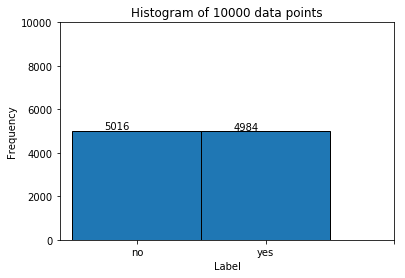

In [9]:
plot_histogram_from_labels(train_labels, labels_legend, "train data")

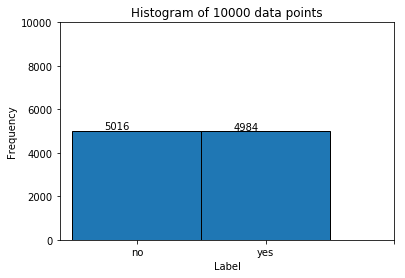

In [10]:
plot_histogram_from_labels(test_labels, labels_legend, "train data")

### Applying preprocessing function

In [11]:
print("\n=== BEFORE ===\n")

print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])


print("\n=== AFTER ===\n")
simple_pre_process_text_df(train_data)
simple_pre_process_text_df(test_data)
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])


=== BEFORE ===

Doe is not poor,  Doe is poor

Hodgson is ambitious,  Hodgson is not ambitious

Hobbes is proud,  Marston is not easy

=== AFTER ===

doe is not poor doe is poor

hodgson is ambitious hodgson is not ambitious

hobbes is proud marston is not easy


## Saving the new version of the data in a csv

In [12]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_v1_train_processed.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_v1_test_processed.csv")


train_data.to_csv(train_data_path, header=False, index=False)
test_data.to_csv(test_data_path, header=False, index=False)

### Starting with torch

We use the `data.Field` to hold all the text data:

> Field class models common text processing datatypes that can be represented
by tensors.  It holds a Vocab object that defines the set of possible values
for elements of the field and their corresponding numerical representations.
The Field object also holds other parameters relating to how a datatype
should be numericalized, such as a tokenization method and the kind of
Tensor that should be produced.

and the class `data.LabelField` to hold the labels:

> A label field is a shallow wrapper around a standard field designed to hold labels
for a classification task. Its only use is to set the unk_token and sequential to `None` by default.

In [13]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(tensor_type=torch.FloatTensor)

And so we can create a dataset by using the class `data.TabularDataset` and the data in the `csv` format

In [14]:
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

test = data.TabularDataset(path=test_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

Creating the train-valid split (80$\%$ for training data and 20$\%$ for validation data)

In [15]:
train, valid = train.split(0.8)

In [16]:
print('len(train):', len(train))
print('len(valid):', len(valid))
print('len(test):', len(test))

len(train): 8000
len(valid): 2000
len(test): 1000


Constructing the Vocabulary, using at maximun 25000 words

In [17]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [18]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 1359
len(LABEL.vocab): 2


Printing the 20 most frequent words

In [19]:
print(TEXT.vocab.freqs.most_common(20))

[('is', 16000), ('not', 8000), ('thankful', 385), ('odd', 375), ('mealy', 375), ('inexpensive', 374), ('proud', 373), ('careful', 370), ('witty', 368), ('faithful', 368), ('better', 366), ('happy', 366), ('eager', 365), ('zealous', 361), ('clever', 357), ('victorious', 355), ('kind', 355), ('delightful', 354), ('gentle', 350), ('brave', 348)]


- `.itos` is the `int2str` method from the object `TEXT.vocab` 
- `.stoi` is the `str2int` method from the object `TEXT.vocab` 

In [20]:
print("TEXT.vocab.itos")
print("word", "index")

for i, word in enumerate(TEXT.vocab.itos[:10]):
    print(word, i)


print()
print("TEXT.vocab.stoi")
print("word", "index")
for word in "i love trump".split():
    print(word, TEXT.vocab.stoi[word])

TEXT.vocab.itos
word index
<unk> 0
<pad> 1
is 2
not 3
thankful 4
mealy 5
odd 6
inexpensive 7
proud 8
careful 9

TEXT.vocab.stoi
word index
i 0
love 970
trump 0


In [21]:
class RNNConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 vocab_size=25000,
                 batch_size=32,
                 embedding_dim=510,
                 rnn_dim=100,
                 output_dim=2,
                 epochs=8,
                 learning_rate=0.5,
                 momentum=0.1):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.rnn_dim = rnn_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "vocab_size = {}\n".format(self.vocab_size)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "embedding_dim = {}\n".format(self.embedding_dim)
        status += "rnn_dim = {}\n".format(self.rnn_dim)
        status += "output_dim = {}\n".format(self.output_dim)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status

Hyperparams

In [22]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab))
print(config)

vocab_size = 1359
batch_size = 32
embedding_dim = 510
rnn_dim = 100
output_dim = 2
epochs = 8
learning_rate = 0.5
momentum = 0.1



To define an iterator that batches examples of similar lengths together we use the class `data.BucketIterator`. 


In [23]:
class DataHolder():
    """
    Class to store all data using the data.BucketIterator class.

    """
    def __init__(self,
                 config,
                 train,
                 valid,
                 test):        
        self.train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
        self.valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
        self.test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)
        
        
b1data = DataHolder(config, train, valid, test) 

We can see some batch examples, here we should remember that the batch shape is `[sent len, batch size]`

In [24]:
batch = next(iter(b1data.train_iter))

print("batch.text.shape = {}".format(batch.text.shape))
print("batch.text.type = {}\n".format(batch.text.type()))
print("batch.label.shape = {}".format(batch.label.shape))
print("batch.label.type = {}\n".format(batch.label.type()))

batch_t = batch.text.transpose(0, 1)
for example in batch_t:
    print()
    print([TEXT.vocab.itos[i] for i in example], end=" ")

batch.text.shape = torch.Size([7, 32])
batch.text.type = torch.LongTensor

batch.label.shape = torch.Size([32])
batch.label.type = torch.FloatTensor


['kyson', 'is', 'not', 'proud', 'posey', 'is', 'powerful'] 
['kimberly', 'is', 'not', 'silly', 'udell', 'is', 'famous'] 
['reid', 'is', 'not', 'wonderful', 'hobson', 'is', 'important'] 
['cuthbert', 'is', 'zealous', 'cuthbert', 'is', 'not', 'zealous'] 
['harper', 'is', 'zealous', 'elfrida', 'is', 'not', 'mealy'] 
['westbrook', 'is', 'silly', 'westbrook', 'is', 'not', 'silly'] 
['dale', 'is', 'not', 'shy', 'dale', 'is', 'shy'] 
['roxbury', 'is', 'not', 'wonderful', 'birney', 'is', 'careful'] 
['hart', 'is', 'wonderful', 'hart', 'is', 'not', 'wonderful'] 
['alden', 'is', 'not', 'rich', 'alden', 'is', 'rich'] 
['millie', 'is', 'calm', 'drummer', 'is', 'not', 'mushy'] 
['lisa', 'is', 'aggressive', 'gardner', 'is', 'not', 'mushy'] 
['burleigh', 'is', 'zealous', 'burleigh', 'is', 'not', 'zealous'] 
['salmon', 'is', 'not', 'vast', 'salmon', 'is

Here we will define the RNN model using the `nn.module` class.

In [25]:
import torch.nn as nn

class CBOW(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.fc = nn.Linear(config.embedding_dim, config.output_dim)
        
    def forward(self, x):
        """
        Apply the model to the input x
        
        :param x: indices of the sentence
        :type x: torch.Tensor(shape=[sent len, batch size]
                              dtype=torch.int64)
        """        
        embedded = self.embedding(x)
        averaged_sentence = torch.mean(embedded, dim=0)
        f = nn.Sigmoid()  
        out = f(self.fc(averaged_sentence))
#         out = self.fc(averaged_sentence)
        return out 

    def predict(self, x):
        out = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_bach(self, batch):
        prediction = model.predict(batch.text)
        labels = batch.label.type('torch.LongTensor')
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct/labels.shape[0])
        return accuracy, prediction, labels

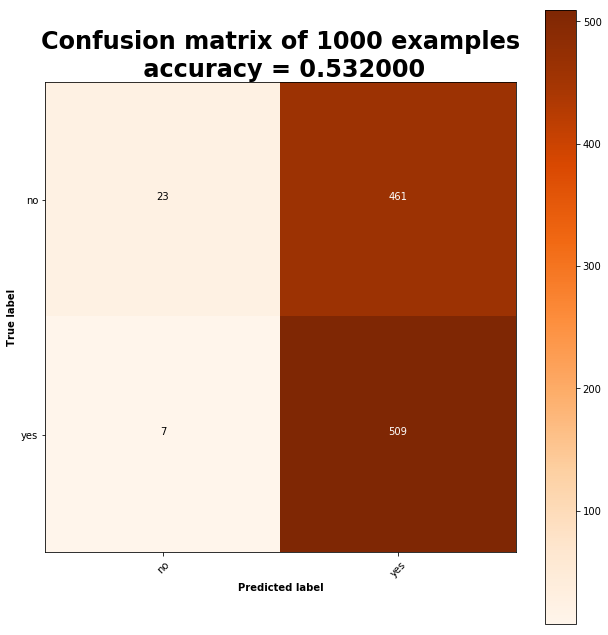

In [26]:
model = CBOW(config)

test_bach = next(iter(b1data.test_iter))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix_b1_v2.png",
                      classes=labels_legend)

## Training functions

In [27]:
def train_in_epoch(model, iterator, optimizer, criterion, negative=False):
    """
    Train the model using all the data from the iterator 

    :param model: RNN classification model
    :type model: RNN 
    :param iterator: data iterator
    :type iterator: data.BucketIterator
    :param optimizer: torch optimizer
    :type optimizer: optim.SGD, etc.
    :param criterion: loss criterion 
    :type criterion: nn.CrossEntropyLoss
    :return: mean loss, mean accuracy
    :rtype: float, float    
    """
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        logits = model(batch.text)
        label = batch.label.type("torch.LongTensor")
        loss = criterion(logits, label)
        if negative:
            loss = - loss
        acc, _, _ = model.evaluate_bach(batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc

    mean_loss = epoch_loss / len(iterator)
    mean_acc = epoch_acc / len(iterator)
        
    return mean_loss, mean_acc


def get_valid_loss(model, valid_iter, criterion):
    """
    Get the valid loss

    :param model: RNN classification model
    :type model: 
    :param valid_iter: valid iterator
    :type valid_iter: data.BucketIterator
    :param criterion: loss criterion 
    :type criterion: nn.CrossEntropyLoss
    :return: valid loss
    :rtype: Tensor(shape=[])    
    """
    batch = next(iter(valid_iter))
    model.eval()
    logits = model(batch.text)
    label = batch.label.type("torch.LongTensor")
    loss = criterion(logits, label)
    return loss

def training_loop_text_classification(model, config, dataholder, model_path, verbose=True, negative=False):
    """
    Train a model for text classification

    :param model: RNN classification model
    :type model: 
    :param config: image classification model
    :type config: LogisticRegression or DFN
    :param dataholder: data
    :type dataholder: DataHolder or DataHolderGentle
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    optimizer = optim.SGD(model.parameters(),
                          lr=config.learning_rate,
                          momentum=config.momentum)
    
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)
    train_iter = dataholder.train_iter
    valid_iter = dataholder.valid_iter
    
    best_valid_loss = float("inf")
    
    all_train_loss = []
    all_valid_loss = []
    
    for epoch in range(config.epochs):

        if verbose:
            print("epoch = ({}/{})".format(epoch + 1, config.epochs))
        train_loss, train_acc = train_in_epoch(model, train_iter, optimizer, criterion, negative)
        all_train_loss.append(train_loss)
        valid_loss = get_valid_loss(model, valid_iter, criterion)
        all_valid_loss.append(valid_loss)

        msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),float(valid_loss))

        if float(valid_loss) < best_valid_loss:
            torch.save(model.state_dict(), model_path)
            best_valid_loss = float(valid_loss)

        if verbose:
            print(msg)
            print("train_acc = {}\n".format(train_acc))

    if verbose:
        x = np.arange(1, len(all_train_loss) + 1, 1)
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.plot(x, all_train_loss, label='mean train loss')
        ax.plot(x, all_valid_loss, label='mean valid loss')
        ax.legend()
        plt.xlabel('epoch')
        plt.ylabel('mean loss')
        plt.title('Train and valid mean loss')
        plt.grid(True)
        plt.show()

## Training the model

epoch = (1/8)

train_loss = 0.695 | valid_loss = 0.694
train_acc = 0.48225

epoch = (2/8)

train_loss = 0.688 | valid_loss = 0.690
train_acc = 0.50425

epoch = (3/8)

train_loss = 0.680 | valid_loss = 0.703
train_acc = 0.533375

epoch = (4/8)

train_loss = 0.673 | valid_loss = 0.676
train_acc = 0.561875

epoch = (5/8)

train_loss = 0.668 | valid_loss = 0.650
train_acc = 0.582125

epoch = (6/8)

train_loss = 0.662 | valid_loss = 0.679
train_acc = 0.596625

epoch = (7/8)

train_loss = 0.658 | valid_loss = 0.653
train_acc = 0.603875

epoch = (8/8)

train_loss = 0.655 | valid_loss = 0.690
train_acc = 0.60875



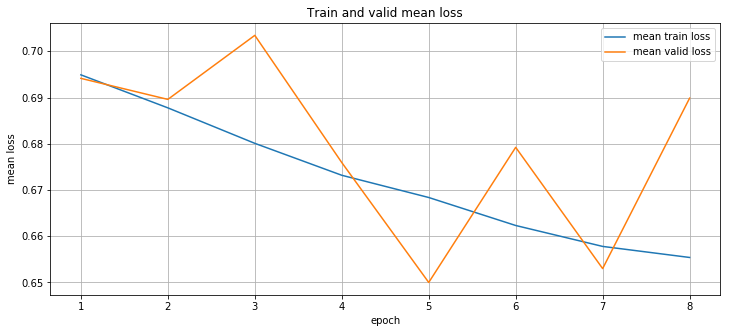

In [28]:
training_loop_text_classification(model,
                                  config,
                                  b1data,
                                  "cbow_v1.pkl")

## Looking at the model after training

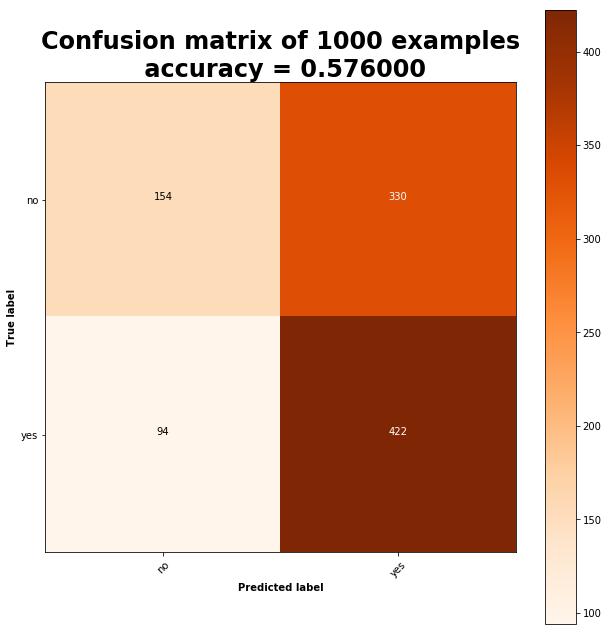

In [29]:
model = CBOW(config)
model.load_state_dict(torch.load('cbow_v1.pkl'))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

## Plotting the results for differtent embedding sizes

size =  10
size =  20
size =  30
size =  40
size =  50
size =  60
size =  70
size =  80
size =  90
size =  100
size =  120
size =  160
size =  200


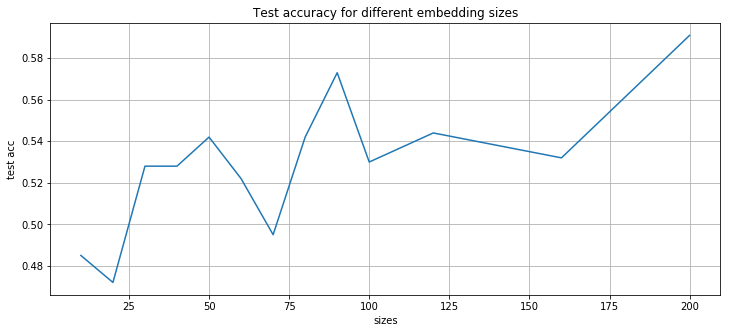

In [30]:
list_of_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 160, 200]
results = []

for size in list_of_sizes:
    print("size = ", size)
    config = RNNConfig(embedding_dim=size)
    model = CBOW(config)
    training_loop_text_classification(model,
                                  config,
                                  b1data,
                                  "cbow_v1.pkl",
                                  verbose=False)
    acc = model.evaluate_bach(test_bach)[0]
    results.append(acc)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(list_of_sizes, results)
plt.xlabel('sizes')
plt.ylabel('test acc')
plt.title('Test accuracy for different embedding sizes')
plt.grid(True)
plt.show()
